In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv').sort_values(['series_id', 'measurement_number'])

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner').sort_values(['series_id', 'measurement_number'])
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Turn data into series

In [4]:
def series_to_supervised(data, features, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in features]
    # Current timestep (t=0)
    cols.append(data)
    names += [(col) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [5]:
window = 5
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id']
use_cols = features + ['surface']
# Train
train_series = series_to_supervised(train[use_cols], features, window=window)
train_series.dropna(inplace=True)        
train_series = train_series[(train_series['series_id'] == train_series['series_id(t-%s)' % window])]
display(train_series.head())

# Test
test_series = series_to_supervised(test[features], features, window=window)
test_series.fillna(test_series.mean(), inplace=True)
# Backwards inputation
for index, row in test_series.iterrows():
    for i in range(1, window+1):
        if row['series_id'] != row['series_id(t-%s)' % i]:
            for feature in features:
                if feature != 'series_id':
                    test_series.at[index, '%s(t-%s)' % (feature, i)] = row[feature]
display(test_series.head())

,orientation_X(t-5),orientation_Y(t-5),orientation_Z(t-5),orientation_W(t-5),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),orientation_X(t-4),orientation_Y(t-4),orientation_Z(t-4),orientation_W(t-4),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),orientation_X(t-2),orientation_Y(t-2),orientation_Z(t-2),orientation_W(t-2),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),orientation_X(t-1),orientation_Y(t-1),orientation_Z(t-1),orientation_W(t-1),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,surface
5,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.0,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.50640,-9.4128,0.0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960,0.0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0,fine_concrete
6,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0,fine_concrete
7,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0,fine_concrete
8,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.0,-0.75851,-0.63445,-0.10485,-0.10559,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,0,fine_concrete
9,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.73497,-9.4296,0.0,-0

,orientation_X(t-5),orientation_Y(t-5),orientation_Z(t-5),orientation_W(t-5),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),orientation_X(t-4),orientation_Y(t-4),orientation_Z(t-4),orientation_W(t-4),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),orientation_X(t-2),orientation_Y(t-2),orientation_Z(t-2),orientation_W(t-2),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),orientation_X(t-1),orientation_Y(t-1),orientation_Z(t-1),orientation_W(t-1),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id
0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.480474,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.484379,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.488284,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.49219,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.496095,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0
1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.480474,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.484379,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.488284,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.49219,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0
2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.480474,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.484379,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.488284,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.00000,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.000000,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0
3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,1907.480474,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,1907.484379,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.00000,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.000000,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0
4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,1907.480474,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000

### Pre process the labels

In [6]:
n_labels =  train_series['surface'].nunique()
labels_names = train_series['surface'].unique()
le = LabelEncoder()
train_series['surface'] = le.fit_transform(train_series['surface'].values)

### Train/validation split

In [7]:
train_splited = []
val_splited = []
gp_surface = train.groupby(['surface', 'series_id'], as_index=False).count()[['surface', 'series_id']]
for surface in gp_surface['surface'].unique():
    df = gp_surface[gp_surface['surface'] == surface]
    tra, val = train_test_split(df, test_size=0.2, random_state=0)
    train_splited += list(tra['series_id'].values)
    val_splited += list(val['series_id'].values)
    
train_splited = pd.DataFrame(train_splited, columns=['series_id'])
val_splited = pd.DataFrame(val_splited, columns=['series_id'])

In [8]:
X_train = train_splited.merge(train_series)
X_val = val_splited.merge(train_series)

Y_train = X_train['surface']
Y_train = to_categorical(Y_train)
X_train.drop('surface', axis=1, inplace=True)
X_train = X_train

Y_val = X_val['surface']
Y_val = to_categorical(Y_val)
X_val.drop('surface', axis=1, inplace=True)
X_val = X_val

series_cols = list(X_train.filter(regex='series_id'))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (374412, 60)
Validation shape (94218, 60)


,orientation_X(t-5),orientation_Y(t-5),orientation_Z(t-5),orientation_W(t-5),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),orientation_X(t-4),orientation_Y(t-4),orientation_Z(t-4),orientation_W(t-4),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),orientation_X(t-2),orientation_Y(t-2),orientation_Z(t-2),orientation_W(t-2),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),orientation_X(t-1),orientation_Y(t-1),orientation_Z(t-1),orientation_W(t-1),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,-0.98321,0.10564,0.009016,-0.14851,0.028959,-0.011703,0.026238,0.032400,4.1378,-8.8985,-0.98321,0.10565,0.009034,-0.14853,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,-0.98321,0.10570,0.009057,-0.14850,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,-0.98321,0.10576,0.009086,-0.14845,0.035360,-0.032865,0.037684,0.16020,3.9802,-9.1033,-0.98321,0.10581,0.009083,-0.14842,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022,-0.98321,0.10583,0.009111,-0.14839,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786
1,-0.98321,0.10565,0.009034,-0.14853,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,-0.98321,0.10570,0.009057,-0.14850,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,-0.98321,0.10576,0.009086,-0.14845,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,-0.98321,0.10581,0.009083,-0.14842,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022,-0.98321,0.10583,0.009111,-0.14839,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,-0.98321,0.10589,0.009124,-0.14834,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355
2,-0.98321,0.10570,0.009057,-0.14850,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,-0.98321,0.10576,0.009086,-0.14845,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,-0.98321,0.10581,0.009083,-0.14842,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,-0.98321,0.10583,0.009111,-0.14839,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,-0.98321,0.10589,0.009124,-0.14834,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,-0.98321,0.10595,0.009126,-0.14827,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271
3,-0.98321,0.10576,0.009086,-0.14845,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,-0.98321,0.10581,0.009083,-0.14842,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,-0.98321,0.10583,0.009111,-0.14839,0.023578,-0.013967,0.033559,-0.426570,4.0422,-9.0786,-0.98321,0.10589,0.009124,-0.14834,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,-0.98321,0.10595,0.009126,-0.14827,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271,-0.98322,0.10600,0.009117,-0.14819,0.065362,-0.005506,0.040376,0.14338,3.3331,-9.2001
4,-0.98321,0.10581,0.009083,-0.14842,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,-0.98321,0.10583,0.009111,-0.14839,0.023578,-0.013967,0.033559,-0.426570,4.0422,-9.0786,-0.98321,0.10589,0.009124,-0.14834,0.034825,-0.020897,0.042671,0.139720,3.6555,-9.5355,-0.98321,0.10595,0.009126,-0.14827,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271,-0.98322,0.10600,0.009117,-0.14819,0.065362,-0.005506,0.040376,0.14338,3.3331,-9.2001,-0.98322,0.10605,0.009131,-0.14817,0.050770,-0.008735,0.042182,-0.25085,3.4112,-8.6230


### Feature engineering

In [9]:
features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe().T)

Train shape (374412, 60)
Validation shape (94218, 60)


,count,mean,std,min,25%,50%,75%,max
orientation_X(t-5),374412.0,-0.011263,0.684469,-0.98898,-0.695612,-0.091329,0.654170,0.98909
orientation_Y(t-5),374412.0,0.087463,0.708118,-0.98965,-0.675490,0.262085,0.816970,0.98898
orientation_Z(t-5),374412.0,0.014341,0.105966,-0.15940,-0.088135,0.035826,0.124430,0.15571
orientation_W(t-5),374412.0,-0.002823,0.104183,-0.15662,-0.103462,-0.017440,0.098702,0.15477
angular_velocity_X(t-5),374412.0,0.000262,0.116795,-2.37100,-0.040808,0.000086,0.040638,2.28220
angular_velocity_Y(t-5),374412.0,0.008466,0.088008,-0.92786,-0.033414,0.005343,0.047913,1.07910
angular_velocity_Z(t-5),374412.0,-0.019526,0.226591,-1.26880,-0.090264,-0.005179,0.065480,1.38730
linear_acceleration_X(t-5),374412.0,0.128795,1.871716,-31.14200,-0.537065,0.123860,0.795427,36.79700
linear_acceleration_Y(t-5),374412.0,2.887226,2.105540,-82.75300,1.958300,2.878900,3.803000,55.94800
linear_acceleration_Z(t-5),374412.0,-9.365155,2.825914,-65.49200,-10.200000,-9.365900,-8.513100,65.83900


### Scale the data

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_series)

In [11]:
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
print('Validation set shape', X_val_series.shape)

Validation set shape (94218, 6, 10)


In [12]:
# X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_val_series = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
# X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train_series = X_train.reshape(X_train.shape[0], (window+1), (X_train.shape[1] // (window+1)))
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
X_test_series = X_test.reshape(X_test.shape[0], (window+1), (X_test.shape[1] // (window+1)))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_val_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (374412, 6, 10)
Validation set shape (94218, 6, 10)
Test set shape (488448, 6, 10)


### Model

In [13]:
epochs = 35
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
# model.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
# model.add(LSTM(15, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 189       
Total params: 2,669
Trainable params: 2,669
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train_series, Y_train, validation_data=(X_val_series, Y_val), epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 374412 samples, validate on 94218 samples
Epoch 1/35
 - 134s - loss: 1.3112 - val_loss: 1.1107
Epoch 2/35
 - 133s - loss: 1.0219 - val_loss: 0.9618
Epoch 3/35
 - 131s - loss: 0.9190 - val_loss: 0.9460
Epoch 4/35
 - 131s - loss: 0.8720 - val_loss: 0.8960
Epoch 5/35
 - 131s - loss: 0.8444 - val_loss: 0.9035
Epoch 6/35
 - 130s - loss: 0.8221 - val_loss: 0.8672
Epoch 7/35
 - 131s - loss: 0.8086 - val_loss: 0.8545
Epoch 8/35
 - 130s - loss: 0.7952 - val_loss: 0.9094
Epoch 9/35
 - 132s - loss: 0.7866 - val_loss: 0.8565
Epoch 10/35
 - 130s - loss: 0.7762 - val_loss: 0.8597
Epoch 11/35
 - 131s - loss: 0.7670 - val_loss: 0.8624
Epoch 12/35
 - 130s - loss: 0.7580 - val_loss: 0.8678
Epoch 13/35
 - 130s - loss: 0.7490 - val_loss: 0.8632
Epoch 14/35
 - 133s - loss: 0.7417 - val_loss: 0.8868
Epoch 15/35
 - 128s - loss: 0.7338 - val_loss: 0.8695
Epoch 16/35
 - 130s - loss: 0.7267 - val_loss: 0.8559
Epoch 17/35
 - 130s - loss: 0.7209 - val_loss:

#### Model loss plot

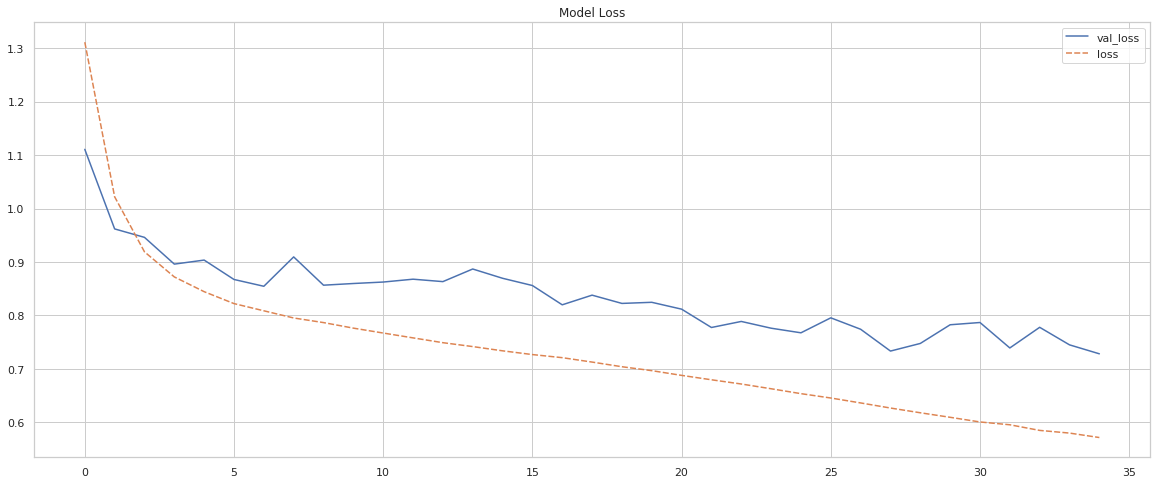

In [16]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [17]:
train_pred = model.predict_classes(X_train_series)
val_pred = model.predict_classes(X_val_series)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.7607955941583069
Validation accuracy 0.7158504744316373


#### Model confusion matrix

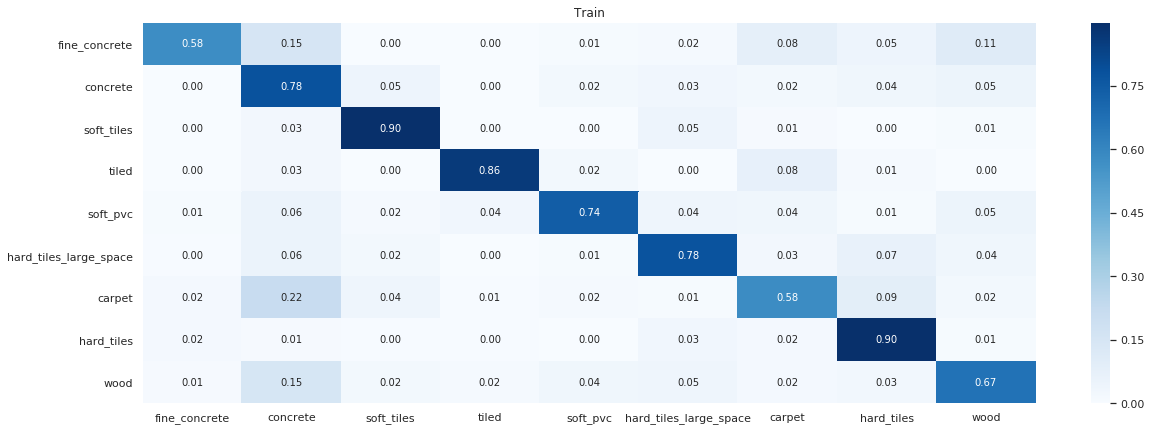

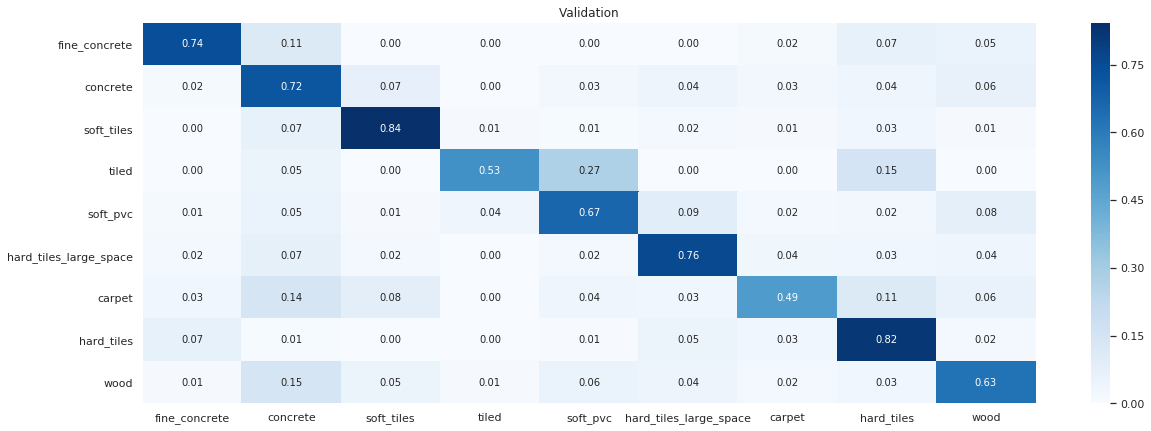

In [18]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [19]:
predictions = model.predict_classes(X_test_series)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)

,series_id,surface
0,0,carpet
1,1,concrete
2,2,tiled
3,3,wood
4,4,tiled
5,5,concrete
6,6,wood
7,7,wood
8,8,concrete
9,9,concrete
